In [1]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from google.colab import files
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from collections import defaultdict

# Dataset

In [2]:
!pip install -q kaggle

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ferys2195","key":"2743c53a4118998088e1ab9100dbcfed"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


## Unduh Dataset

In [5]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

 99% 527M/534M [00:02<00:00, 252MB/s]
100% 534M/534M [00:02<00:00, 231MB/s]


In [6]:
!unzip -q vegetable-image-dataset.zip

In [7]:
path_data = "/content/Vegetable Images/train"

In [8]:
def create_dataset(dir):
    for entri in os.listdir(dir):
        path_entri = os.path.join(dir, entri)
        if os.path.isfile(path_entri):
            os.remove(path_entri)
    print("Dataset Created")

In [9]:
create_dataset(os.path.join(path_data))

Dataset Created


In [10]:
data = os.path.join(path_data)
list_data = os.listdir(data)
print(list_data)

['Carrot', 'Papaya', 'Bottle_Gourd', 'Bitter_Gourd', 'Radish', 'Cucumber', 'Capsicum', 'Cabbage', 'Brinjal', 'Tomato', 'Bean', 'Pumpkin', 'Broccoli', 'Cauliflower', 'Potato']


## Mendapatkan Jumlah Kelas

In [11]:
class_size = len(list_data)
print(class_size)

15


## Melihat ukuran dimensi gambar dan Menghitung Jumlah Dataset

In [12]:
size_count = defaultdict(int)

total = 0

for x in list_data:
    dir = os.path.join(path_data, x)
    img_files = os.listdir(dir)

    for img_file in img_files:
        img_path = os.path.join(dir, img_file)
        try:
            with Image.open(img_path) as img:
                size_count[img.size] += 1
        except IOError:
            print(f"Tidak dapat membuka {img_file}")

    total += len(img_files)
print("Total :", total)
print("----------------")
print("Ukuran gambar:")
for size, count in size_count.items():
    print(f"- {size} : {count}")

Total : 15000
----------------
Ukuran gambar:
- (224, 224) : 14994
- (224, 211) : 1
- (224, 210) : 1
- (224, 198) : 1
- (224, 205) : 1
- (224, 193) : 1
- (224, 200) : 1


## Tampilkan Sample Dataset

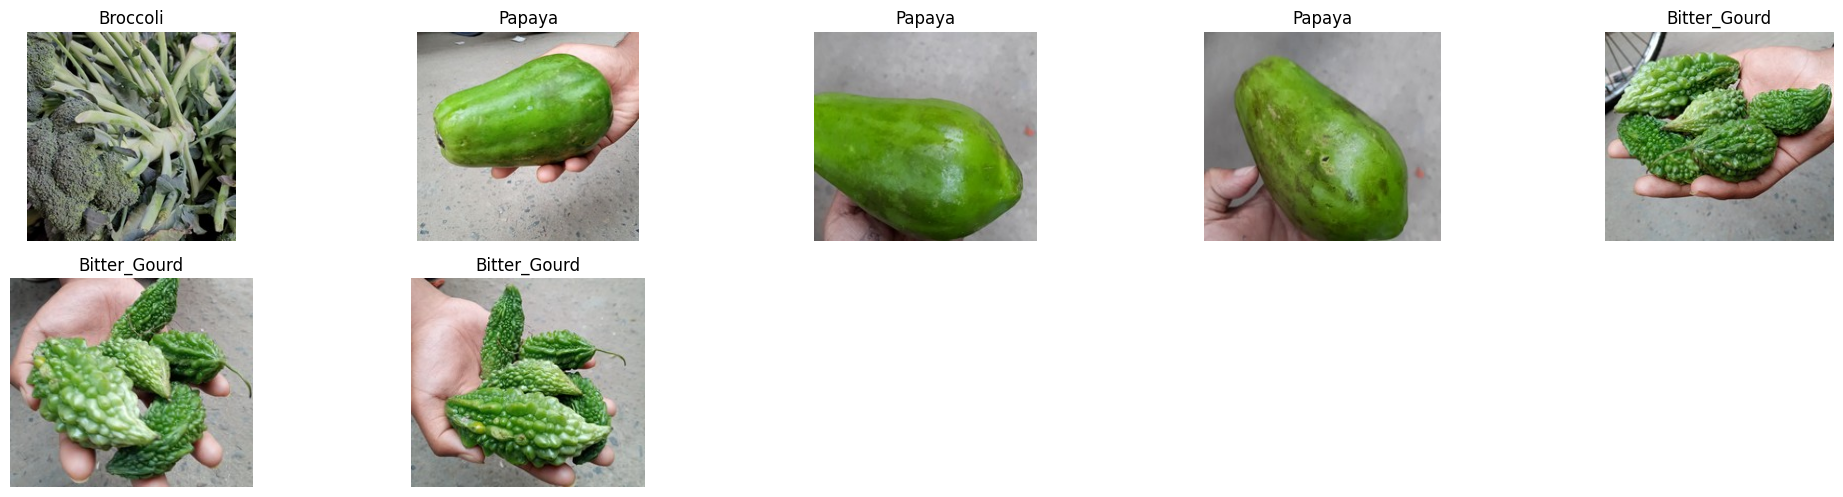

In [23]:
all_images = []
sizes = defaultdict(list)
sample = 7

for class_name in os.listdir(path_data):
    class_path = os.path.join(path_data, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        try:
            with Image.open(image_path) as img:
                size = img.size
                sizes[size].append((image_path, class_name))
        except IOError:
            print(f"Tidak dapat membuka {image_path}")

selected_images = []
for size, images in sizes.items():
    selected_images.append(random.choice(images))
    if len(selected_images) >= sample:
        break

if len(selected_images) < sample:
    print(f"Tidak cukup gambar dengan ukuran unik untuk menampilkan {sample} gambar.")

plt.figure(figsize=(20, 10))
for i, (image_path, class_name) in enumerate(selected_images, 1):
    plt.subplot(4, 5, i)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Menyiapkan Datagen menggunakan ImageDataGenerator Untuk Dataset

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)



## Split Dataset

In [15]:
batch_size = 32
img_height = 224
img_width = 224

In [16]:
train_generator = train_datagen.flow_from_directory(
    data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 12000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


# Model

## Buat Model Sequential

In [17]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(class_size, activation='softmax')
])


model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

## Buat Callback

In [18]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAccuracy above 92%, finish training!")
      self.model.stop_training = True


callbacks = [myCallback(), EarlyStopping(monitor='val_accuracy', patience=5, start_from_epoch=20)]

## Latih Model

In [19]:
history = model.fit(train_generator,
                      epochs = 40,
                      validation_data = validation_generator,
                      verbose = 2,
                      callbacks = callbacks)

Epoch 1/40
375/375 - 179s - loss: 1.6984 - accuracy: 0.4032 - val_loss: 1.2008 - val_accuracy: 0.6033 - 179s/epoch - 479ms/step
Epoch 2/40
375/375 - 164s - loss: 1.0626 - accuracy: 0.6372 - val_loss: 0.7132 - val_accuracy: 0.7717 - 164s/epoch - 437ms/step
Epoch 3/40
375/375 - 163s - loss: 0.7308 - accuracy: 0.7498 - val_loss: 0.4652 - val_accuracy: 0.8420 - 163s/epoch - 434ms/step
Epoch 4/40
375/375 - 163s - loss: 0.5651 - accuracy: 0.8134 - val_loss: 0.4498 - val_accuracy: 0.8417 - 163s/epoch - 435ms/step
Epoch 5/40
375/375 - 163s - loss: 0.4391 - accuracy: 0.8529 - val_loss: 0.4981 - val_accuracy: 0.8327 - 163s/epoch - 436ms/step
Epoch 6/40
375/375 - 163s - loss: 0.3797 - accuracy: 0.8724 - val_loss: 0.2278 - val_accuracy: 0.9290 - 163s/epoch - 434ms/step
Epoch 7/40
375/375 - 162s - loss: 0.3497 - accuracy: 0.8851 - val_loss: 0.1728 - val_accuracy: 0.9523 - 162s/epoch - 432ms/step
Epoch 8/40
375/375 - 163s - loss: 0.3081 - accuracy: 0.8961 - val_loss: 0.1839 - val_accuracy: 0.9520 - 

# Result

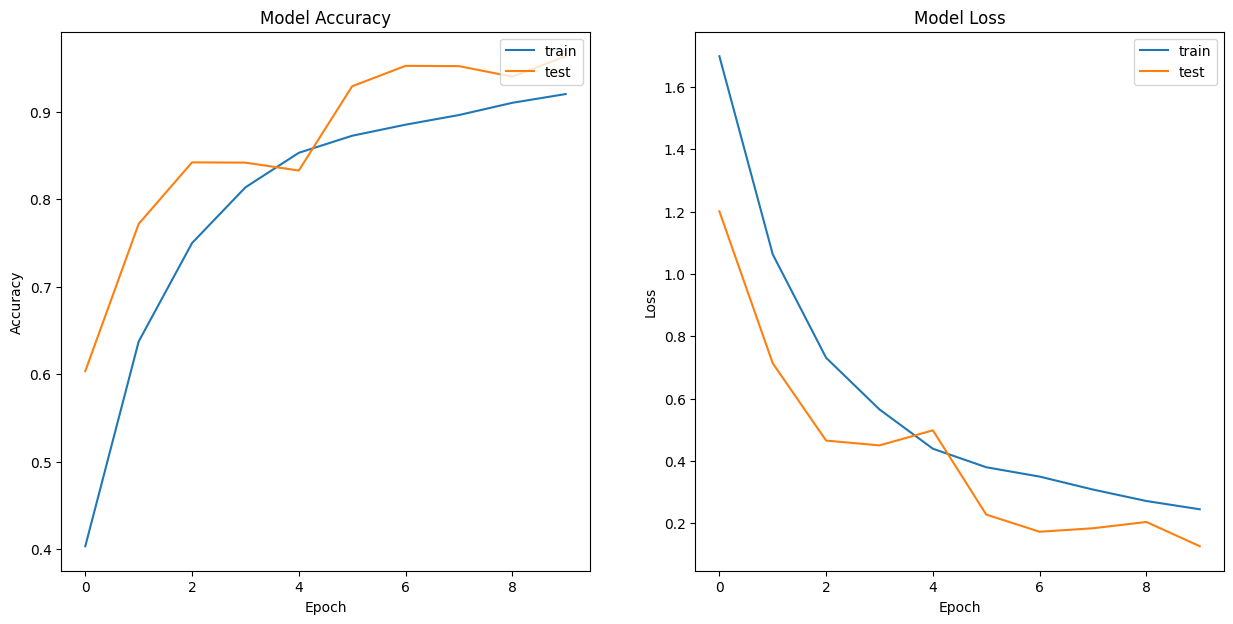

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1]})

axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'test'], loc='upper right')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'test'], loc='upper right')

plt.show()

# Export Model

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)